In [1]:
import pandas as pd
import os

# GF TODO: check if excel present, otherwise download it
# wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

excel_with_path  = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.xlsx'
pickle_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.pkl'
csv_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.csv'

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)

df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# df.to_csv(csv_with_path, encoding = 'utf-8')

# GF TODO: there are nan 
# GF TODO: there are fields which are 'empty char', e.g. in the customer_id

-> picke already exists, much faster



In [2]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


##  Are there users at high risk of churning by the end of 2011

- https://www.kdnuggets.com/2019/05/churn-prediction-machine-learning.html 
- https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
- https://www.google.com/search?q=dwarf+on+the+shoulders+of+giants&rlz=1C5CHFA_enCH771CH771&sxsrf=ALeKk034vLLmAHn5V1c0QAON4DZuO1GqVA:1582207255390&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiRrayrpeDnAhXCxaYKHZQVCgcQ_AUoAXoECBIQAw&biw=1418&bih=915#imgrc=oj4GwW0aHYfVYM
- similar exercise resolved here https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf
- the repo of the library to be used https://github.com/CamDavidsonPilon/lifetimes
- the reference paper in pdf http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf http://brucehardie.com/papers/bgnbd_2004-04-20.pdf and the journal which has all aspects of a respectable journals 
- GF TODO: once you've found which customers have churned, make a few hitory plots to prove that indeed they have churned, to show that I am not blindly trusing the package I've downloade



- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?


- NOT SURE IF USEFUL some stack-overflow like explanations about the Pareto model https://stats.stackexchange.com/questions/251506/is-it-possible-to-understand-pareto-nbd-model-conceptually

In [3]:
# pip install --user lifetimes
print('pip install worked out fine')

pip install worked out fine


In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

In [5]:
help(summary_data_from_transaction_data)

Help on function summary_data_from_transaction_data in module lifetimes.utils:

summary_data_from_transaction_data(transactions, customer_id_col, datetime_col, monetary_value_col=None, datetime_format=None, observation_period_end=None, freq='D', freq_multiplier=1)
    Return summary data from transactions.
    
    This transforms a DataFrame of transaction data of the form:
        customer_id, datetime [, monetary_value]
    to a DataFrame of the form:
        customer_id, frequency, recency, T [, monetary_value]
    
    Parameters
    ----------
    transactions: :obj: DataFrame
        a Pandas DataFrame that contains the customer_id col and the datetime col.
    customer_id_col: string
        the column in transactions DataFrame that denotes the customer_id
    datetime_col:  string
        the column in transactions that denotes the datetime the purchase was made.
    monetary_value_col: string, optional
        the columns in the transactions that denotes the monetary value of

##   RFM variables and negative/cancellation transactions
- frequency, recency, T
- how do I deal with transactions, in producing the RFM models ?
- for now just exclude them: cancellations are likely to correlate to churning behaviour, however the frequency of positive transactions is what the pareto model uses and expects to predict churning probabilty
- ===> check if there's correlation between churning behaviour and frequency of cancellations ?  

## FOR the moment I exclude cancellations from the type of transactions to compute RFM variables

In [6]:
columns_forRFM = ['Customer_ID','InvoiceDate','Transaction']
df_forRFM = df[columns_forRFM][df['Transaction']>0]
#df_forRFM = df[['Customer_ID','InvoiceDate','Transaction']]

In [7]:
df_forRFM.head(3)

,Customer_ID,InvoiceDate,Transaction
0,13085.0,2009-12-01 07:45:00,83.4
1,13085.0,2009-12-01 07:45:00,81.0
2,13085.0,2009-12-01 07:45:00,81.0


In [8]:
RFM = summary_data_from_transaction_data(df_forRFM,'Customer_ID','InvoiceDate',monetary_value_col='Transaction',freq='D')

In [9]:
RFM.head(5)

,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


## RFM info


DEFINITIONS
- Recency: time between initial purchase and most recent (last) purchase
- Frequency: number of repeat purchases made by a customer (total purchases — 1)
- Monetary: total spent on purchases

FUNCTION summary_data_from_transaction_data
- it's a rather clever thing: it AGGREGATES into 1 all transactions taking place at the same DAY!

In [10]:
#RFM.describe()

# Verifiaction of how summary_data_from_transaction_data
- for a few Customer_Id randomly picked, Frequency makes sense 

# SHOULD I RESTRICT MOST OF THE ANALYSIS AND PLOTS TO CUSTOMERS WHO HAVE RETURNED?
- if a customer has haver come back, it's probably dead anyway...
- and all the values at 0 are somewhat disturbing

In [11]:
# df_forRFM[df_forRFM['Customer_ID']==12346.0].sort_values(by=['InvoiceDate'],ascending=False)
#df_forRFM[df_forRFM['Customer_ID']==12346.0].InvoiceDate.unique()
# len(df[df['Customer_ID']==12346.0].InvoiceDate.unique())
df_forRFM[df_forRFM['Customer_ID']==12347.0].InvoiceDate.unique()

array(['2010-10-31T14:20:00.000000000', '2010-12-07T14:57:00.000000000',
       '2011-01-26T14:30:00.000000000', '2011-04-07T10:43:00.000000000',
       '2011-06-09T13:01:00.000000000', '2011-08-02T08:48:00.000000000',
       '2011-10-31T12:25:00.000000000', '2011-12-07T15:52:00.000000000'],
      dtype='datetime64[ns]')

In [12]:
RFM.columns

Index([u'frequency', u'recency', u'T', u'monetary_value'], dtype='object')

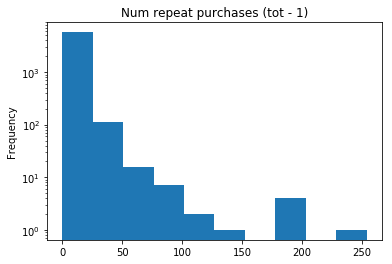

In [13]:
tit='Num repeat purchases (tot - 1)'
RFM['frequency'].plot(kind='hist',logy=True,title=tit)

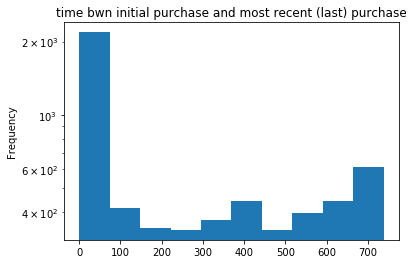

In [14]:
tit='time bwn initial purchase and most recent (last) purchase'
RFM['recency'].plot(kind='hist',logy=True,title=tit)

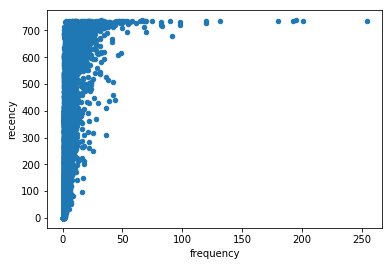

In [15]:
RFM.plot.scatter(x='frequency',y='recency')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2be57d110>,
      dtype=object)

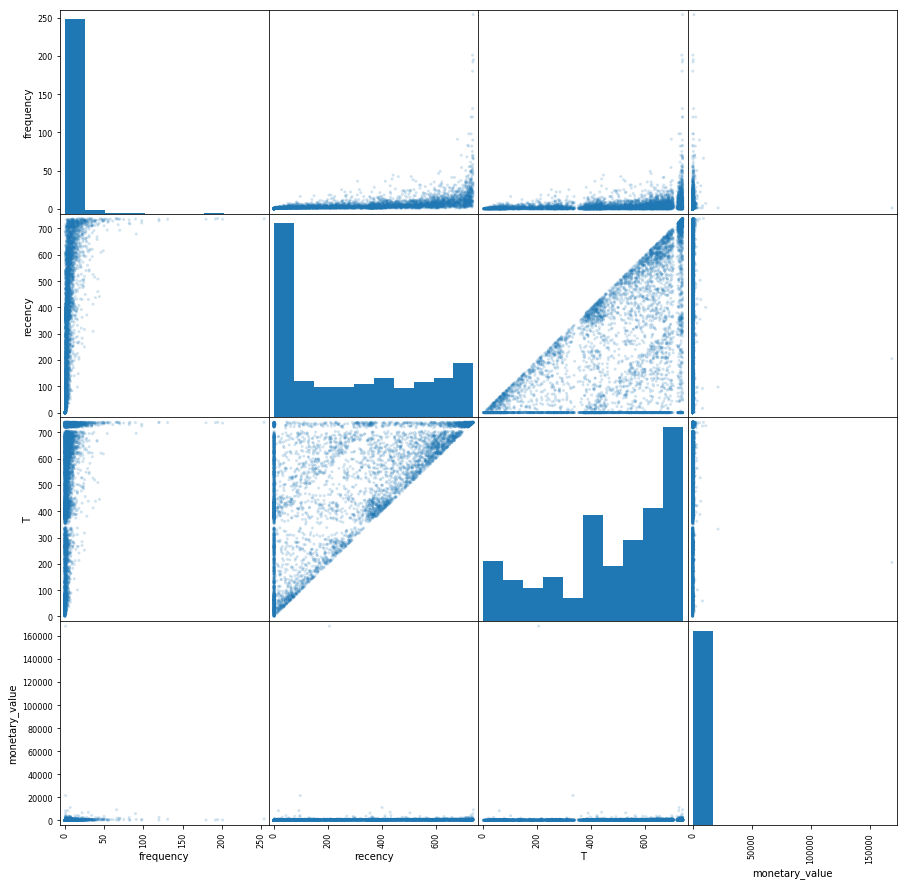

In [16]:
pd.plotting.scatter_matrix(RFM, alpha=0.2,figsize=(15,15))

# Assumptions of the BG/NBD model:
- A customer’s relationship has two phases: “alive” for an unobserved period of time, then “dead”
- While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate lambda
- Heterogeneity in lambda follows a gamma distribution
- After any transaction, a customer dies with probability p; the probability that a customer dies after a number of transactions follows a geometric distribution
- p follows a beta distribution
- Lambda and p vary independently across customers

# seen these references
- https://medium.com/data-shopify/how-shopify-merchants-can-measure-retention-c12284bfed6f
- http://brucehardie.com/papers/bgnbd_2004-04-20.pdf (of which I have other url's as well)


# For follow up

- how many customers are there with more than 50/75 purchases ?
  Perhaps worth selecting those out and treating them separately ?

In [17]:
help(BetaGeoFitter)

Help on class BetaGeoFitter in module lifetimes.fitters.beta_geo_fitter:

class BetaGeoFitter(lifetimes.fitters.BaseFitter)
 |  Also known as the BG/NBD model.
 |  
 |  Based on [2]_, this model has the following assumptions:
 |  
 |  1) Each individual, i, has a hidden lambda_i and p_i parameter
 |  2) These come from a population wide Gamma and a Beta distribution
 |     respectively.
 |  3) Individuals purchases follow a Poisson process with rate lambda_i*t .
 |  4) After each purchase, an individual has a p_i probability of dieing
 |     (never buying again).
 |  
 |  Parameters
 |  ----------
 |  penalizer_coef: float
 |      The coefficient applied to an l2 norm on the parameters
 |  
 |  Attributes
 |  ----------
 |  penalizer_coef: float
 |      The coefficient applied to an l2 norm on the parameters
 |  params_: :obj: Series
 |      The fitted parameters of the model
 |  data: :obj: DataFrame
 |      A DataFrame with the values given in the call to `fit`
 |  variance_matrix_: 

In [18]:
beta_gf = BetaGeoFitter(penalizer_coef=0.0)
beta_gf.fit(RFM['frequency'], RFM['recency'], RFM['T']);

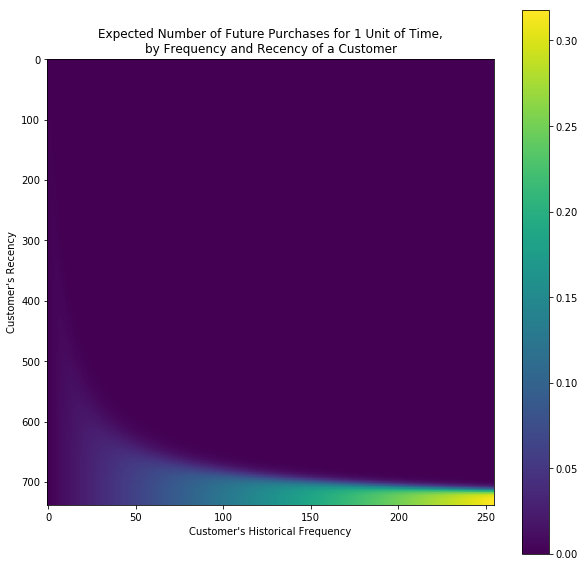

In [19]:
# https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/plotting.py#L211
fig = plt.figure(figsize=(10,10))
plot_frequency_recency_matrix(beta_gf);

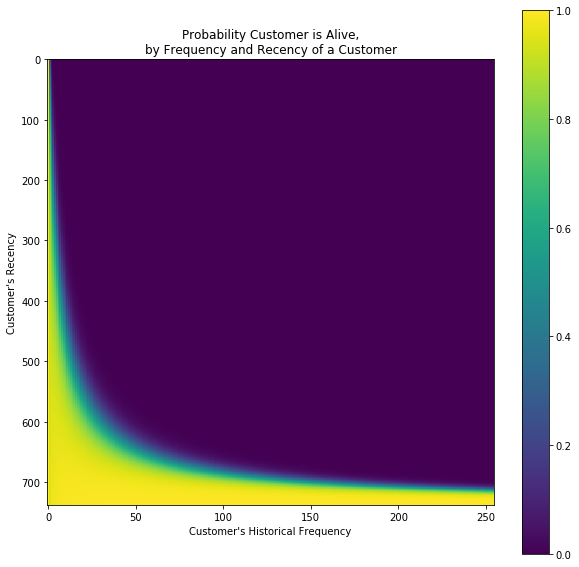

In [20]:
fig = plt.figure(figsize=(10,10))
plot_probability_alive_matrix(beta_gf);

<Figure size 720x720 with 0 Axes>

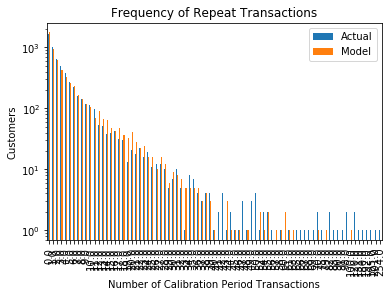

In [21]:
fig = plt.figure(figsize=(10,10))
plot_period_transactions(beta_gf, max_frequency=250).set_yscale('log')

<Figure size 720x720 with 0 Axes>

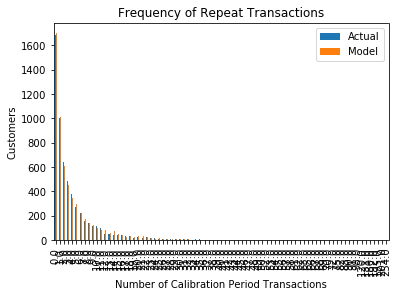

In [22]:
fig = plt.figure(figsize=(10,10))
plot_period_transactions(beta_gf, max_frequency=250)

In [23]:
data_star='2009-12-01'
calib_end='2011-05-31'
obser_end='2011-12-09'

from datetime import date
d_data_star=date( * map(lambda u:int(u), data_star.split('-') ) )
d_calib_end=date( * map(lambda u:int(u), calib_end.split('-') ) )
d_obser_end=date( * map(lambda u:int(u), obser_end.split('-') ) )

data_span = (d_obser_end - d_data_star).days
data_train= (d_calib_end - d_data_star).days
print('data cover overall %d days, of which %d are used for training'%(data_span,data_train))

data cover overall 738 days, of which 546 are used for training


In [24]:
# https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/utils.py#L27

#  Create a summary of each customer over a calibration and holdout period.
#  This function creates a summary of each customer over a calibration and holdout period
#  (training and testing, respectively).
    
summary_cal_holdout = calibration_and_holdout_data(df_forRFM,'Customer_ID','InvoiceDate',
                                                    calibration_period_end=calib_end,
                                                    observation_period_end=obser_end)

In [25]:
summary_cal_holdout.sort_values(by=['frequency_cal'],ascending=False).head(5)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
14911.0,169.0,541.0,546.0,85.0,192
15311.0,147.0,542.0,546.0,47.0,192
14606.0,136.0,542.0,544.0,44.0,192
12748.0,128.0,539.0,543.0,72.0,192
17841.0,123.0,541.0,545.0,69.0,192


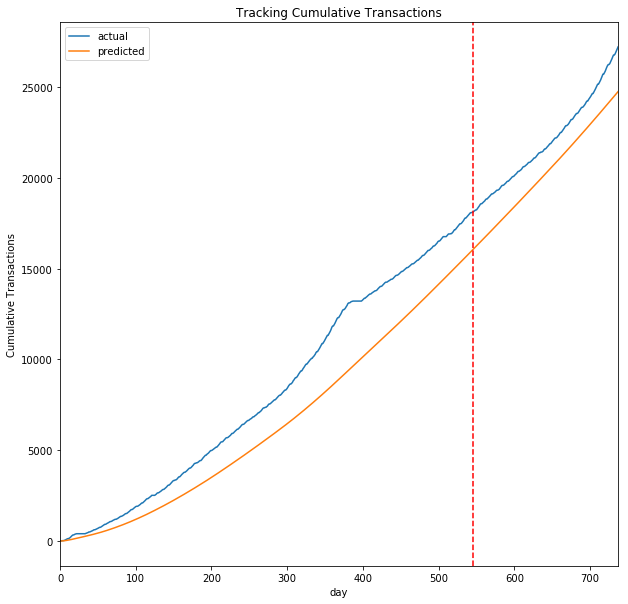

In [26]:
fig = plt.figure(figsize=(10,10))

# non-store online retail between 01/12/2009 and 09/12/2011

beta_gf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(beta_gf, df_forRFM, 'InvoiceDate', 'Customer_ID', data_span, data_train);

In [27]:
# is it correct we have only 25k transaction, as a result of aggregation of all of those into a single day?

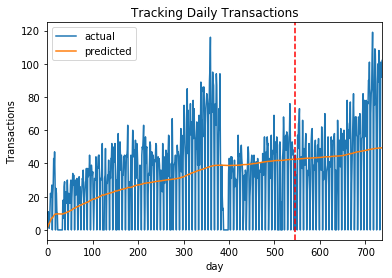

In [28]:
plot_incremental_transactions(beta_gf, df_forRFM,'InvoiceDate', 'Customer_ID', data_span, data_train);

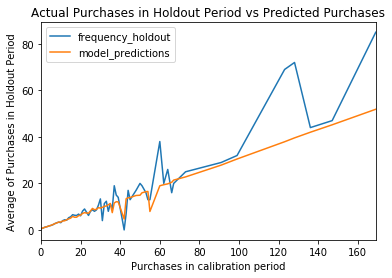

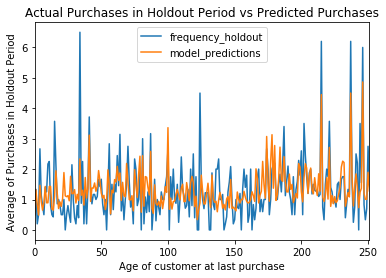

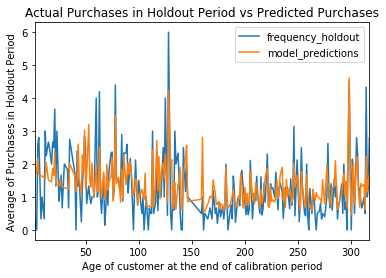

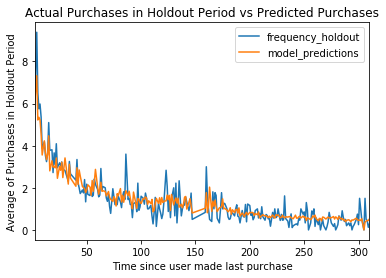

In [29]:
#k="frequency_cal"               # Purchases in calibration period,
#k="recency_cal"                 # Age of customer at last purchase,
#k="T_cal"                       # Age of customer at the end of calibration period,
#k="time_since_last_purchase"    # Time since user made last purchase

for k in ['frequency_cal','recency_cal','T_cal','time_since_last_purchase']:
    plot_calibration_purchases_vs_holdout_purchases(beta_gf, summary_cal_holdout,n=250,kind=k);

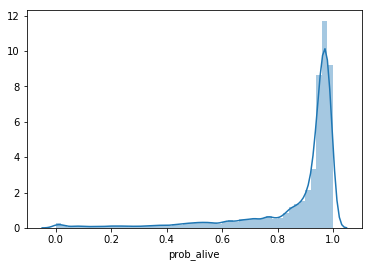

In [30]:
# select only the customers who have come back already at least once
RFM_returned = RFM[RFM['frequency']>0]
RFM_returned['prob_alive'] = beta_gf.conditional_probability_alive(RFM_returned['frequency'],
                                                                   RFM_returned['recency'],RFM_returned['T'])
sns.distplot(RFM_returned['prob_alive'])

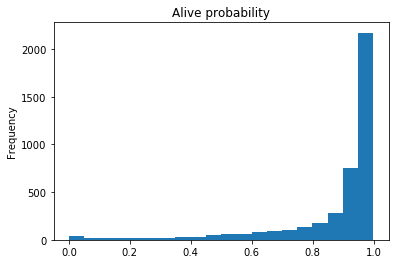

In [31]:
tit='Alive probability'
RFM_returned['prob_alive'].plot(kind='hist',bins=20,title=tit)

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


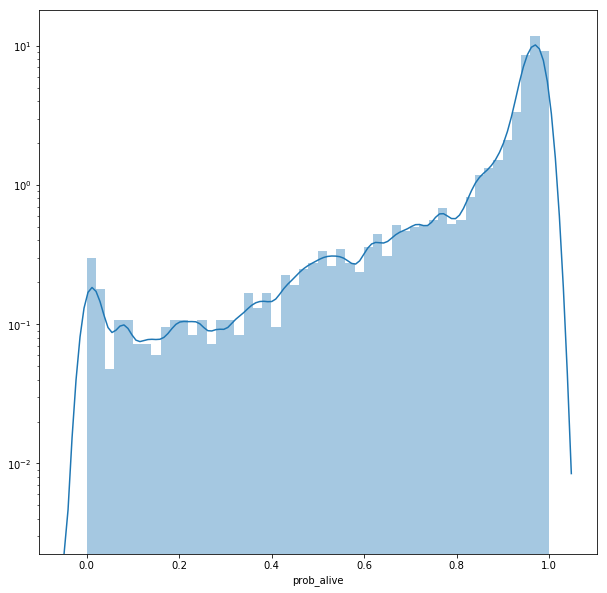

In [32]:
fig = plt.figure(figsize=(10,10))
sns.distplot(RFM_returned['prob_alive'], hist_kws={'log':True})

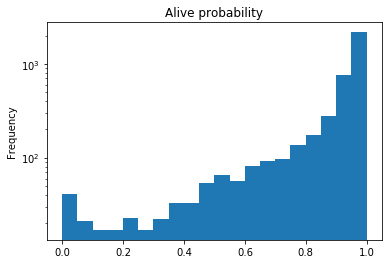

In [33]:
RFM_returned['prob_alive'].plot(kind='hist',logy=True,bins=20,title=tit)

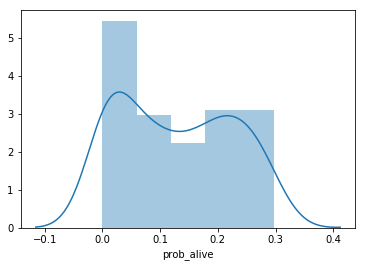

In [34]:
sns.distplot(RFM_returned.loc[RFM_returned.prob_alive < 0.3]['prob_alive'])

In [35]:
RFM_returned.columns

Index([u'frequency', u'recency', u'T', u'monetary_value', u'prob_alive'], dtype='object')

there are 62 customers with very low probability of being alive (i.e. 0.1 or less)


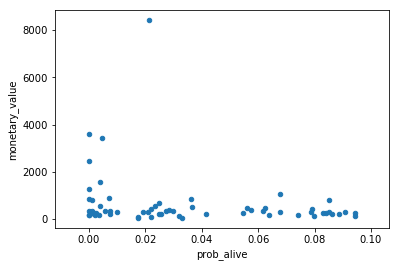

In [36]:
prob_alive_sel = 0.1
RFM_returned.loc[RFM_returned.prob_alive < prob_alive_sel].plot.scatter(x='prob_alive',y='monetary_value')
# the customers at risk of churning are not very very valuable
print('there are %d customers with very low probability of being alive (i.e. %s or less)'% (len(RFM_returned.loc[RFM_returned.prob_alive < prob_alive_sel]),prob_alive_sel))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2ac609f90>,
      dtype=object)

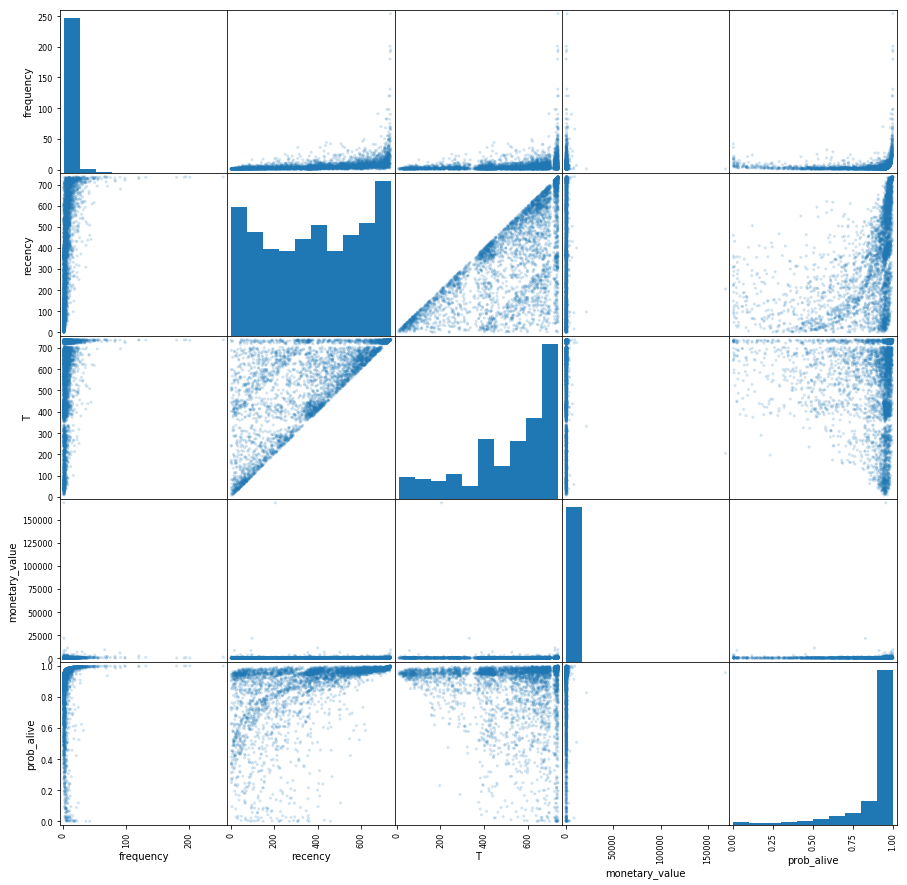

In [37]:
pd.plotting.scatter_matrix(RFM_returned, alpha=0.2,figsize=(15,15))

## Have any users churned during the second half of 2011? 
- I define them as users who have a low prob of being alive at the end of 2011 and had higher prob mid 2011
## Are there any users at high risk of churning by the end of 2011?
- users who have low live probabiliy at the end of 2011 and didn't mid 2011 

- split the users in three populations: dead, alive, high rish
- answer to first  question: number of users who were alive|risk in may 2011 and are dead at the end of 2011
- answer to second question: number of users who are at high risk at the end of 2011

## no need of splitting the customers to train/apply: I just train and verify goodness on variables other than those used. THERE IS NO GROUND TRUTH available in the training data
